In [1]:
import numpy as np
import os
import pandas as pd
import re
import gc 
import random
import os
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [2]:
def df_to_np(df): #convert df to np array, seperate labels and attack
    X = df.iloc[:,0:-2].to_numpy()
    y = df.iloc[:,-2:].to_numpy()
    return X, y

def seperate_label_attack(y):
    a = y[:,0]
    y = np.asarray(y[:,1]).astype('int8')
    return y, a

def split_train_val(df, val_ratio):
    df_val = df[df['Attack']=='Benign'].sample(frac=(val_ratio/2))
    df_val = pd.concat([df_val, df[df['Attack']!='Benign'].sample(frac=(val_ratio/2))], axis=0)
    df.drop(df_val.index, inplace=True)
    return df, df_val

def bgta_ub(df, attacks, r): #benign count gt anomaly count
    try:
        df_tr = df[df['Label']==1]
        total_benign = int(round(len(df_tr.index)/(1-r))*(r))
        df_tr = pd.concat([df_tr, df[df['Label'] == 0].sample(n=total_benign)], axis=0)
    except:
        df_tr = pd.DataFrame()
        for attack in attacks:
            df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(frac=0.5)], axis=0)
        n_ben = len(df_tr.index)
        df_tr = pd.concat([df_tr, df[df['Label'] == 0].sample(n=round((len(df_tr.index))/(1-r)))], axis=0)
    df.drop(df_tr.index, inplace=True)
    return df, df_tr

def agtb_ub(df, attacks, r): #benign count gt anomaly count
    tot_dist = df['Label'].value_counts()
    df_tr = df[df['Label']==0]
    total_anomaly = int(round(len(df_tr.index)/r)*(1-r))
    f = total_anomaly/(tot_dist[1])
    for attack in attacks:
        df_tr = pd.concat([df_tr, df[df['Attack'] == attack].sample(frac=f)], axis=0)
    df.drop(df_tr.index, inplace=True)
    return df, df_tr

def unbalance_train(df, r):
    attacks = df[df['Attack'] != 'Benign']['Attack'].unique()
    value_c = df[df['Attack'] != 'Benign']['Attack'].value_counts()
    tot_dist = df['Label'].value_counts()
    if tot_dist[0] > tot_dist[1]:
        df, df_tr = bgta_ub(df, attacks, r)
    else:
        df, df_tr = agtb_ub(df, attacks, r)
    return df, df_tr

## Configurables

In [3]:
#                      0              1                              2                 3
files = ['NF-BoT-IoT-v2.csv', 'NF-CSE-CIC-IDS2018-v2.csv', 'NF-ToN-IoT-v2b.csv', 'NF-UNSW-NB15-v2.csv'] #CNB15-syntheticddos

isolate = 1
val_ratio = 0.25
r=0.8 #benign to anomaly ratio for train, val sets
r_t = r #benign to anomaly ratio for test set
folder= 'oboa/'
dir = '../../../Datasets/NF-UQ-NIS-2/Original Dataset/' #original dataset directory
rboa_new_test_file = 'rboa/rb_r8_NF-CSE-CIC-IDS2018-v2.csv'

d = {#'L4_SRC_PORT': np.int32,
  'L4_DST_PORT': np.int32,
  'PROTOCOL': np.int32,
 'L7_PROTO': np.float64,
  'IN_BYTES': np.int32,
#  'IN_PKTS': np.int32,
#  'OUT_BYTES': np.int32,
#  'OUT_PKTS': np.int32,
#  'TCP_FLAGS': np.int32,
#  'CLIENT_TCP_FLAGS': np.int32,
#  'SERVER_TCP_FLAGS': np.int32,
 'FLOW_DURATION_MILLISECONDS': np.int32,
 'DURATION_IN': np.int32,
#  'DURATION_OUT': np.int32,
#  'MIN_TTL': np.int32,
#  'MAX_TTL': np.int32,
#  'LONGEST_FLOW_PKT': np.int32,
#  'SHORTEST_FLOW_PKT': np.int32,
#  'MIN_IP_PKT_LEN': np.int32,
#  'MAX_IP_PKT_LEN': np.int32,
# 'SRC_TO_DST_SECOND_BYTES': np.float64,
# 'DST_TO_SRC_SECOND_BYTES': np.float64,
#  'RETRANSMITTED_IN_BYTES': np.int32,
#  'RETRANSMITTED_IN_PKTS': np.int32,
#  'RETRANSMITTED_OUT_BYTES': np.int32,
#  'RETRANSMITTED_OUT_PKTS': np.int32,
#  'SRC_TO_DST_AVG_THROUGHPUT': np.int32,
#  'DST_TO_SRC_AVG_THROUGHPUT': np.int32,
#  'NUM_PKTS_UP_TO_128_BYTES': np.int32,
#  'NUM_PKTS_128_TO_256_BYTES': np.int32,
#  'NUM_PKTS_256_TO_512_BYTES': np.int32,
#  'NUM_PKTS_512_TO_1024_BYTES': np.int32,
#  'NUM_PKTS_1024_TO_1514_BYTES': np.int32,
  'TCP_WIN_MAX_IN': np.int32,
  'TCP_WIN_MAX_OUT': np.int32,
#  'ICMP_TYPE': np.int32,
#  'ICMP_IPV4_TYPE': np.int32,
#  'DNS_QUERY_ID': np.int32,
#  'DNS_QUERY_TYPE': np.int32,
#  'DNS_TTL_ANSWER': np.int32,
#  'FTP_COMMAND_RET_CODE': np.int32
    }

headers = list(d.keys())
headers.extend(('Attack', 'Label'))

print('Isolating: {0}'.format(files[isolate]))
isolated = files[isolate]
files.pop(isolate)
print(files)

Isolating: NF-CSE-CIC-IDS2018-v2.csv
['NF-BoT-IoT-v2.csv', 'NF-ToN-IoT-v2b.csv', 'NF-UNSW-NB15-v2.csv']


## Generate Train and Validation Data

In [4]:
pd.DataFrame(columns=headers).to_csv(folder+'/3_train.csv', header=True, index=None)
pd.DataFrame(columns=headers).to_csv(folder+'/3_test.csv', header=True, index=None)
pd.DataFrame(columns=headers).to_csv(folder+'/3_val.csv', header=True, index=None)
pd.DataFrame(columns=headers).to_csv(folder+'/3_lo.csv', header=True, index=None)
pd.DataFrame(columns=headers).to_csv(folder+'/3_lof.csv', header=True, index=None)
    
for file in files:
    print('Processing {0}'.format(file))
    df_te = pd.read_csv(dir+file, usecols=['Label','Attack'])
    print('Balancing data')
    df_te, df_tr = unbalance_train(df_te, r)
    print('Total Benign Data used for train & val:{0}'.format((len(df_tr[df_tr['Label']==0].index))))
    print('Total Attack Data used for train & val:{0}'.format((len(df_tr[df_tr['Label']==1].index))))
    df_tr, df_val = split_train_val(df_tr, val_ratio)
    
    te_index = df_te.index.to_list()
    tr_index = df_tr.index.to_list()
    val_index = df_val.index.to_list()

    #clear up memory in RAM
    del df_tr
    del df_te
    del df_val
    gc.collect()
    df_tr = pd.DataFrame()
    df_te = pd.DataFrame()
    df_val = pd.DataFrame()
    
    #save to file
    print('Saving files for {0}'.format(file))
    for chunk in pd.read_csv(dir+file, usecols=headers, dtype=d, chunksize=10000000, iterator=True):
        chunk.loc[[n for n in tr_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_train.csv', mode = 'a', header=None, index=0)
        chunk.loc[[n for n in val_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_val.csv', mode = 'a', header=None, index=0)
        chunk.loc[[n for n in te_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_lo.csv', mode = 'a', header=None, index=0)

Processing NF-BoT-IoT-v2.csv
Balancing data
Total Benign Data used for train & val:135037
Total Attack Data used for train & val:33759
Saving files for NF-BoT-IoT-v2.csv
Processing NF-ToN-IoT-v2b.csv
Balancing data
Total Benign Data used for train & val:6099469
Total Attack Data used for train & val:1524866
Saving files for NF-ToN-IoT-v2b.csv
Processing NF-UNSW-NB15-v2.csv
Balancing data
Total Benign Data used for train & val:380212
Total Attack Data used for train & val:95053
Saving files for NF-UNSW-NB15-v2.csv


## Generate Test Set from Leftover Data

Generating test set. below is leftover data


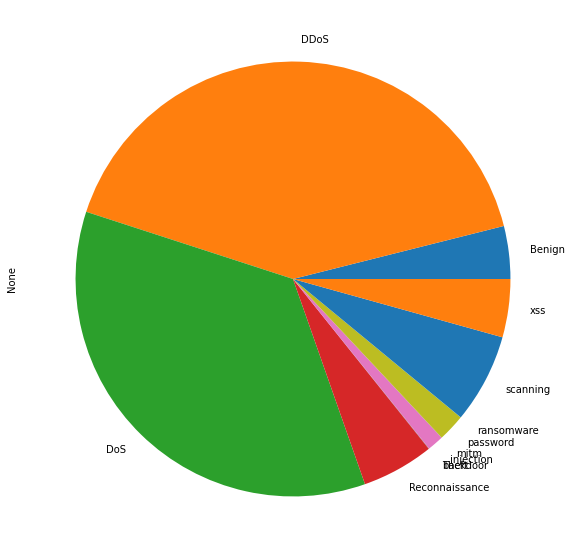

Attack
Benign             1915010
DDoS              20056630
DoS               17270600
Reconnaissance     2618648
Theft                 2429
backdoor             14445
injection           588190
mitm                  6637
password            991100
ransomware            2943
scanning           3249536
xss                2109704
dtype: int64

Saving Files
Deleting old leftover file and clearing memory


3443

In [5]:
print('Generating test set. below is leftover data')
df_lo = pd.read_csv(folder+'3_lo.csv', usecols=['Label','Attack'])

count_series = df_lo.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)

df_lo, df_te = unbalance_train(df_lo, r_t)

lof_index = df_lo.index.to_list()
te_index = df_te.index.to_list()

print('\nSaving Files')
for chunk in pd.read_csv(folder+'3_lo.csv', dtype=d, chunksize=10000000, iterator=True):
        chunk.loc[[n for n in lof_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_lof.csv', mode = 'a', header=None, index=0)
        chunk.loc[[n for n in te_index if n in range(chunk.index.start,chunk.index.stop)]].to_csv(folder+'3_test.csv', mode = 'a', header=None, index=0)

        
print('Deleting old leftover file and clearing memory')        
os.remove(folder+'3_lo.csv')

del df_te
del df_lo
gc.collect()


## Breakdown of all generated files

3_train.csv

p: 0.8000001658639313


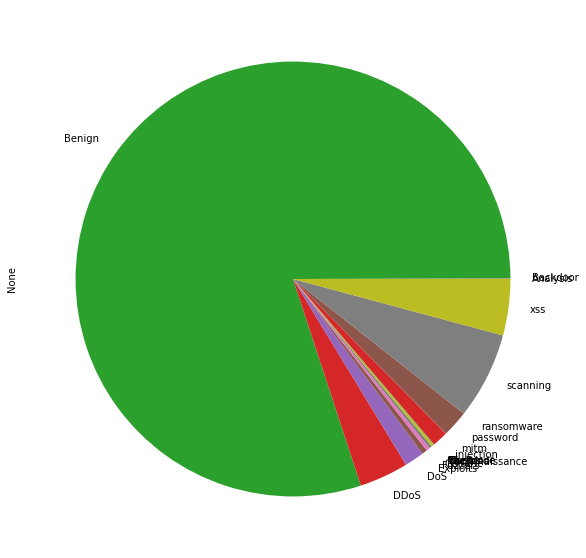

Attack
Analysis             2032
Backdoor             1923
Benign            5787878
DDoS               263665
DoS                105834
Exploits            27637
Fuzzers             19452
Generic             14465
Reconnaissance      13291
Shellcode            1241
Theft                   2
Worms                 144
backdoor             2044
injection           84169
mitm                  951
password           141837
ransomware            415
scanning           465405
xss                302461
dtype: int64

-------------------------------------
3_val.csv

p: 0.8


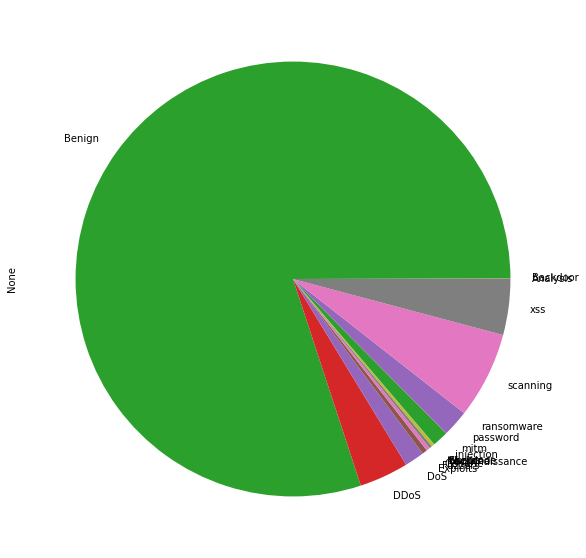

Attack
Analysis             267
Backdoor             246
Benign            826840
DDoS               37786
DoS                15152
Exploits            3914
Fuzzers             2858
Generic             2095
Reconnaissance      1839
Shellcode            186
Worms                 20
backdoor             320
injection          12106
mitm                 135
password           20386
ransomware            67
scanning           66478
xss                42855
dtype: int64

-------------------------------------
3_test.csv

p: 0.80000016710099


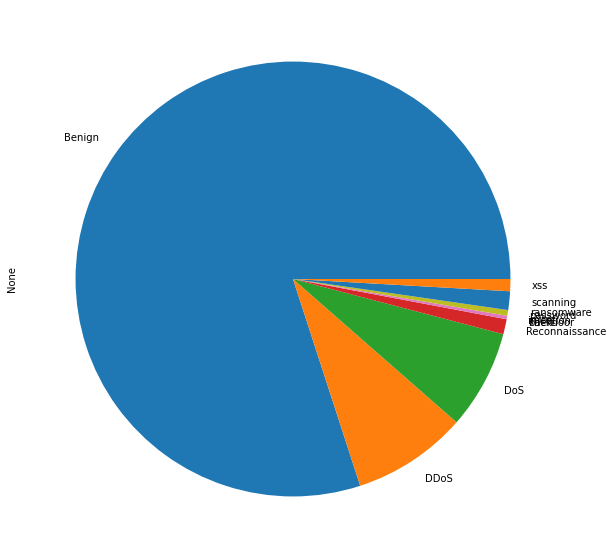

Attack
Benign            1915010
DDoS               204689
DoS                176256
Reconnaissance      26725
Theft                  25
backdoor              147
injection            6003
mitm                   68
password            10115
ransomware             30
scanning            33163
xss                 21531
dtype: int64

-------------------------------------
3_lof.csv

p: 0.0


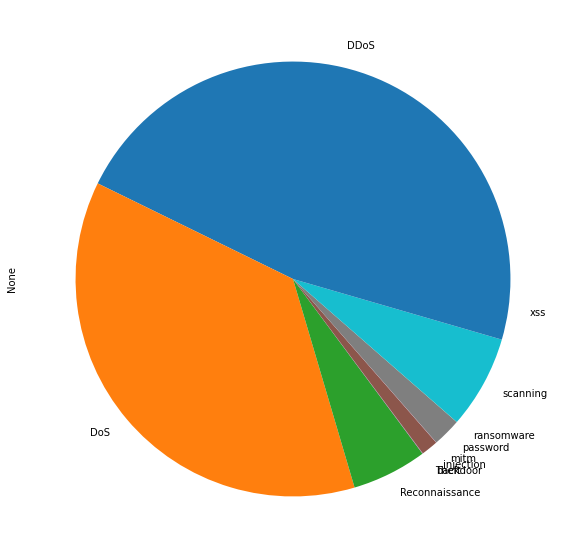

Attack
DDoS              19851941
DoS               17094344
Reconnaissance     2591923
Theft                 2404
backdoor             14298
injection           582187
mitm                  6569
password            980985
ransomware            2913
scanning           3216373
xss                2088173
dtype: int64

-------------------------------------


In [6]:
files = ['3_train.csv', '3_val.csv', '3_test.csv', '3_lof.csv']
for file in files:
    print(file+'\n')
    df = pd.read_csv(folder+file, usecols=['Label','Attack'])
    print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))   
    count_series = df.groupby(['Attack']).size()
    count_series.plot(kind='pie', figsize=(10,10))
    plt.show()
    print(count_series)
    print('\n-------------------------------------')
    del df
    gc.collect()

## Scale Train, Validation and Test Sets

In [4]:
scaler = StandardScaler()

print('Generating training data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_train.csv', dtype=d).sample(frac=1))
X = scaler.fit_transform(X)
y, a = seperate_label_attack(y)
np.save(folder+'X_train.npy', X)
np.save(folder+'y_train.npy', y)

print('Generating validation data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_val.csv', dtype=d).sample(frac=1))
X = scaler.transform(X)
y, a = seperate_label_attack(y)
np.save(folder+'X_val.npy', X)
np.save(folder+'y_val.npy', y)

print('Generating test data numpy arrays')
X, y = df_to_np(pd.read_csv(folder+'3_test.csv', dtype=d).sample(frac=1))
X = scaler.transform(X)
y, a = seperate_label_attack(y)
np.save(folder+'X_test.npy', X)
np.save(folder+'y_test.npy', y)
        
del X
del y
del a
gc.collect()

Generating training data numpy arrays
Generating validation data numpy arrays
Generating test data numpy arrays


0

## Generate Final Test Set with number of benign samples equal to RBOA
If Error, run RBOA preprocess script and return. Ensure RBOA r value is the same

Generating test 2 data numpy arrays
p: 0.8160971708585152


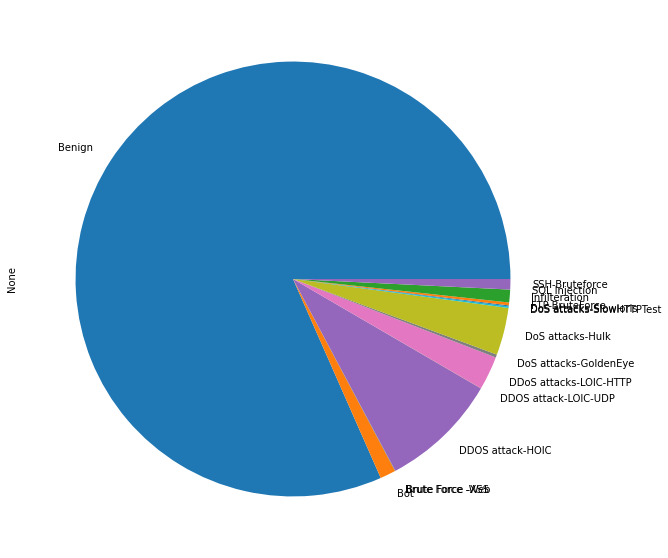

Attack
Benign                      10020849
Bot                           143097
Brute Force -Web                2143
Brute Force -XSS                 927
DDOS attack-HOIC             1080858
DDOS attack-LOIC-UDP            2112
DDoS attacks-LOIC-HTTP        307300
DoS attacks-GoldenEye          27723
DoS attacks-Hulk              432648
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           9512
FTP-BruteForce                 25933
Infilteration                 116361
SQL Injection                    432
SSH-Bruteforce                 94979
dtype: int64
p: 0.8160971708585152


In [5]:
isolated = rboa_new_test_file
print('Generating test 2 data numpy arrays')
df = pd.read_csv(isolated, dtype=d, usecols=headers)
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
count_series = df.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
X_1_ar, y_1_ar = df_to_np(df)
X_1_ar = scaler.transform(X_1_ar)
y_1_ar, a_1_ar = seperate_label_attack(y_1_ar)

np.save(folder+'X_1.npy', X_1_ar)
np.save(folder+'y_1.npy', y_1_ar)
np.save(folder+'a_1.npy', a_1_ar)

## Final Test Set with attacks not expected to be detected removed

Generating test 2 data numpy arrays
p: 0.9325517003527855


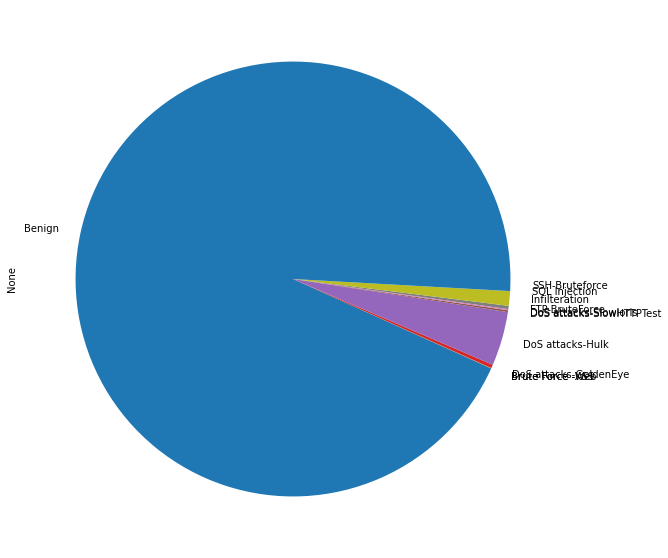

Attack
Benign                      10020849
Brute Force -Web                2143
Brute Force -XSS                 927
DoS attacks-GoldenEye          27723
DoS attacks-Hulk              432648
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           9512
FTP-BruteForce                 25933
Infilteration                 116361
SQL Injection                    432
SSH-Bruteforce                 94979
dtype: int64


7147

In [6]:
print('Generating test 2 data numpy arrays')
df = pd.read_csv(isolated, dtype=d, usecols=headers)
df.drop(df[df['Attack'] == 'DDOS attack-HOIC'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'DDoS attacks-LOIC-HTTP'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'DDOS attack-LOIC-UDP'].sample(frac=1).index, inplace=True)
df.drop(df[df['Attack'] == 'Bot'].sample(frac=1).index, inplace=True)
print('p:', str(len(df[df['Label'] == 0].index)/len(df.index)))
count_series = df.groupby(['Attack']).size()
count_series.plot(kind='pie', figsize=(10,10))
plt.show()
print(count_series)

X_1_ar, y_1_ar = df_to_np(df)
X_1_ar = scaler.transform(X_1_ar)
y_1_ar, a_1_ar = seperate_label_attack(y_1_ar)

np.save(folder+'X_1_ar.npy', X_1_ar)
np.save(folder+'y_1_ar.npy', y_1_ar)
np.save(folder+'a_1_ar.npy', a_1_ar)


del X_1_ar
del y_1_ar
del a_1_ar
del df
gc.collect()